In [1]:
from fastai import *
from fastai.vision import *

/home/tinhpt/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## **Path of dataset**

In [2]:
path='/home/tinhpt/Desktop/flowers/'

# **Preparing Data**
1. Splitting data into 80:20 ratio
2. Resized input image to 224 * 224 pixels
3. Normalizing data

In [3]:
data=ImageDataBunch.from_folder(path+"flowers",valid_pct=0.20,ds_tfms=get_transforms(),size=224).normalize(imagenet_stats)
data

ImageDataBunch;

Train: LabelList (3459 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
daisy,daisy,daisy,daisy,daisy
Path: /home/tinhpt/Desktop/flowers/flowers;

Valid: LabelList (864 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
rose,rose,tulip,sunflower,tulip
Path: /home/tinhpt/Desktop/flowers/flowers;

Test: None

## **Display of Random Images**

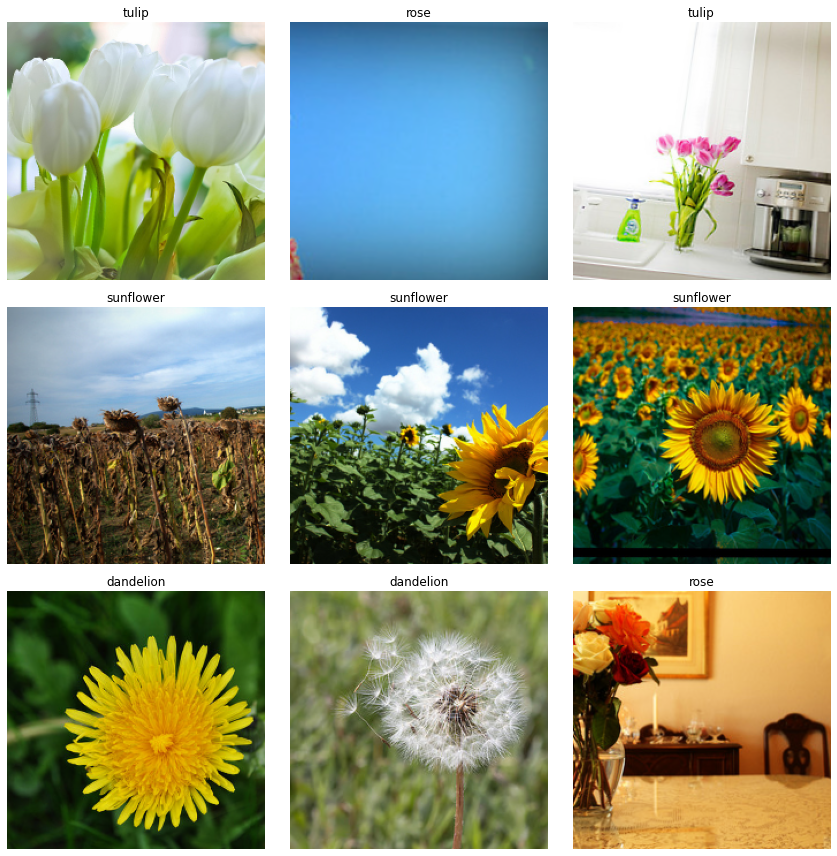

In [4]:
data.show_batch(rows=3,fig=(5,5))

## Creating Callback Save Best Model During Traing

In [5]:
class SaveBestModel(Recorder):
    def __init__(self, learn,name='best_model'):
        super().__init__(learn)
        self.name = name
        self.best_loss = None
        self.best_acc = None
        self.save_method = self.save_when_acc
        
    def save_when_acc(self, metrics): 
        try:
            loss, acc = metrics[0], metrics[1]
            if self.best_acc == None or acc > self.best_acc:
                self.best_acc = acc
                self.best_loss = loss
                self.learn.save(f'{self.name}')
                print("Save the best accuracy {:.5f}".format(self.best_acc))
            elif acc == self.best_acc and  loss < self.best_loss:
                self.best_loss = loss
                self.learn.save(f'{self.name}')
                print("Accuracy is eq,Save the lower loss {:.5f}".format(self.best_loss))
        except StandardError: 
            print("index out of range")
    def on_epoch_end(self,last_metrics=MetricsList,**kwargs:Any):
        self.save_method(last_metrics)
            

# **Creaing Densenet201 Model Architecture**

In [6]:
model=cnn_learner(data,models.resnet34,metrics=accuracy, callback_fns=SaveBestModel)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/tinhpt/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


## Summary of Densenet201 Model

In [7]:
model.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

# Training Model with 5 epochs

In [8]:
model.fit_one_cycle(5)

Save the best accuracy 0.88773
Save the best accuracy 0.89005
Save the best accuracy 0.89931
Save the best accuracy 0.90394


###### Loss Graph

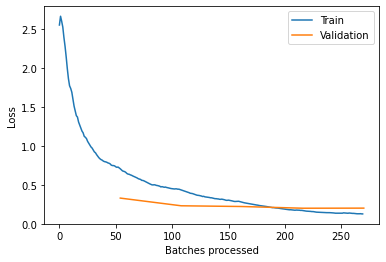

In [20]:
model.recorder.plot_losses()

## Testset Accuracy plot

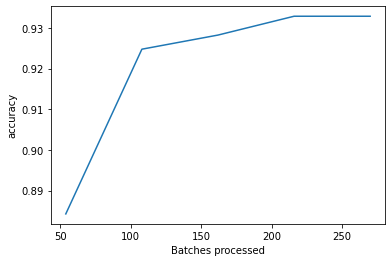

In [21]:
model.recorder.plot_metrics()

## Learning rate plot

lr is made constant on this training i.e 0.003

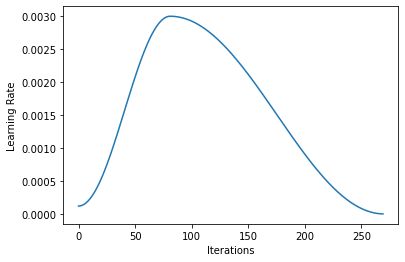

In [22]:
model.recorder.plot_lr()

In [23]:
#model.unfreeze() # must be done before calling lr_find
model.lr_find()
model.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


NameError: name 'StandardError' is not defined

In [24]:
model.fit_one_cycle(4, max_lr=slice(3e-5, 3e-4))

Save the best accuracy 0.93519
Save the best accuracy 0.93634
Accuracy is eq,Save the lower loss 0.18355


In [25]:
model.save('flower-detection-stage-1')

In [26]:
from fastai.widgets import *

ds, idxs = DatasetFormatter().from_toplosses(model)
ImageCleaner(ds, idxs, path)

'No images to show :)'

In [29]:
df = pd.read_csv('/home/tinhpt/Desktop/flowers/cleaned.csv', header='infer')
print(df.head())

db = (ImageList.from_df(df, path)
                   .random_split_by_pct(0.2)
                   .label_from_df()
                   .transform(get_transforms(), size=224)
                   .databunch(bs=8)).normalize(imagenet_stats)

                                         name  label
0  flowers/daisy/34266042310_9c1abd8e11_n.jpg  daisy
1    flowers/daisy/14698531521_0c2f0c6539.jpg  daisy
2   flowers/daisy/3080880039_4f1bd592e5_n.jpg  daisy
3    flowers/daisy/14421389519_d5fd353eb4.jpg  daisy
4    flowers/daisy/14907815010_bff495449f.jpg  daisy


/home/tinhpt/anaconda3/lib/python3.8/site-packages/fastai/data_block.py:217: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [30]:
print(data.classes, data.c, len(data.train_ds), len(data.valid_ds))
print(db.classes, db.c, len(db.train_ds), len(db.valid_ds))

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'] 5 3459 864
['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'] 5 2733 683


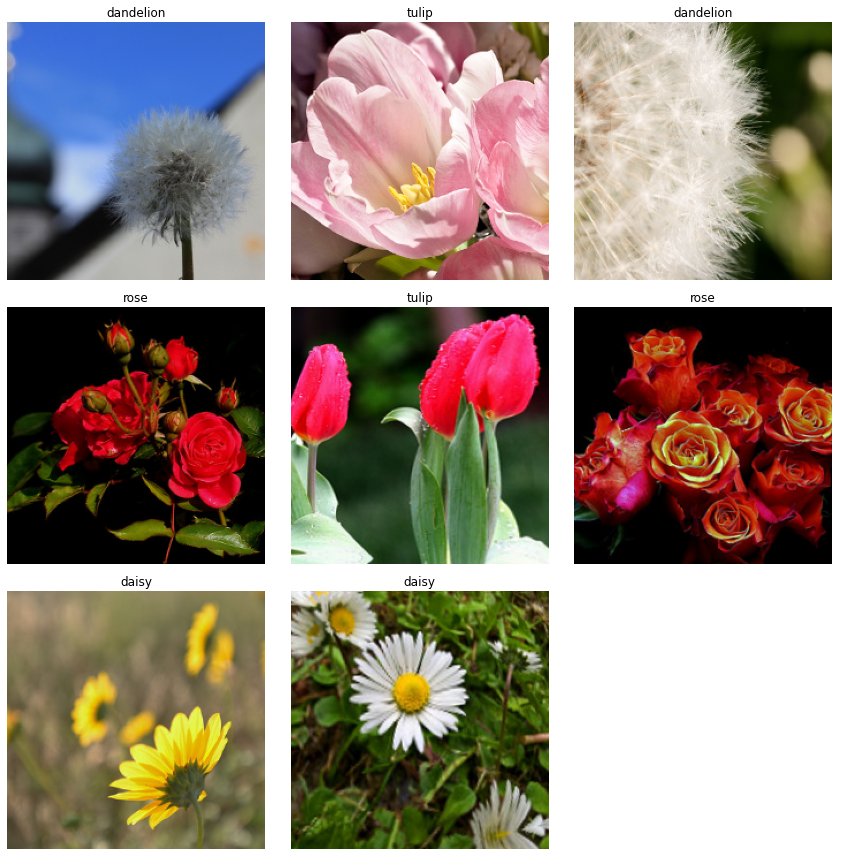

In [31]:
db.show_batch()

In [34]:
model.load('flower-detection-stage-1') # loading the weights
model.data = db # replacing the data

model.freeze()
model.fit_one_cycle(4)

model.unfreeze()

#model.lr_find()
#model.recorder.plot()

model.fit_one_cycle(4, max_lr=slice(3e-5, 3e-4))
model.save('animal-detection-stage-2')

Save the best accuracy 0.92094
Save the best accuracy 0.94436
Save the best accuracy 0.95168
Save the best accuracy 0.96340


Save the best accuracy 0.92679
Save the best accuracy 0.93119
Save the best accuracy 0.95754
Save the best accuracy 0.96925


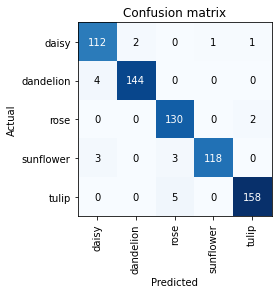

In [35]:
interp=ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix(title='Confusion matrix')

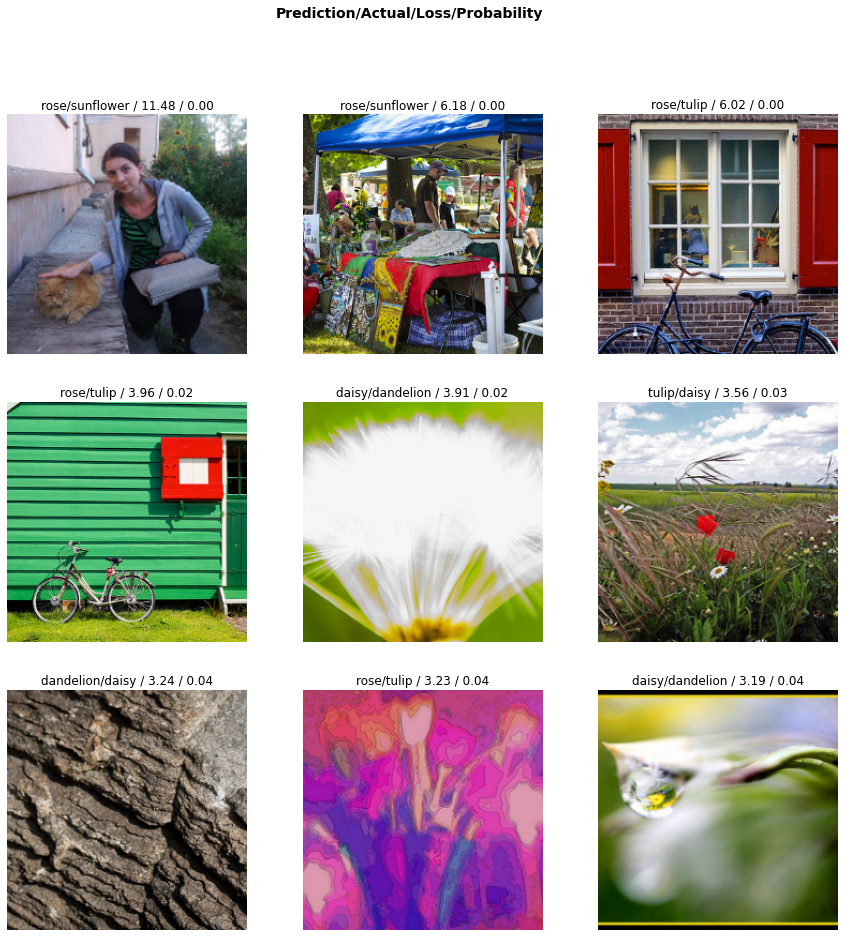

In [36]:
interp.plot_top_losses(9, figsize=(15,15))

In [37]:
model.export('flower.pkl')

<h2> TEST </h2>

In [31]:
btn_upload = widgets.FileUpload()
btn_upload


FileUpload(value={}, description='Upload')

In [65]:
from PIL import Image

In [66]:
img = PILImage.create(btn_upload.data)
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl:
    display(img.to_thumb(128,128))
    outpl
pred,pred_idx,prods = model.predic(img)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction:{pred}; Probabilitiy: {probs[pred_idx]:.o4f}'
lpl_pred

NameError: name 'PILImage' is not defined